In [0]:
# Update fastai
!curl -s https://course.fast.ai/setup/colab | bash

# Link GDrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

# Lesson 6: pets revisited

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [0]:
bs = 64

In [0]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [5]:
doc(get_transforms)

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
data = get_data(224, bs, 'zeros')

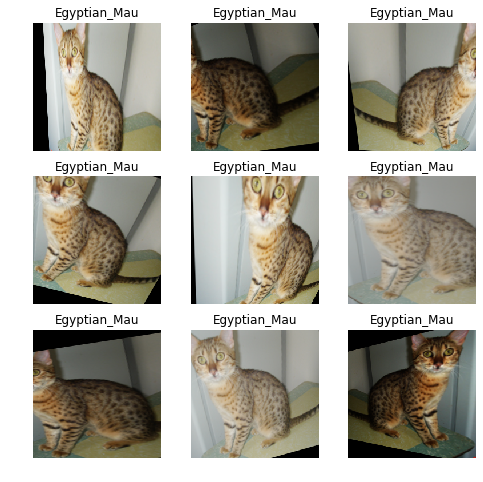

In [9]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
data = get_data(224,bs)

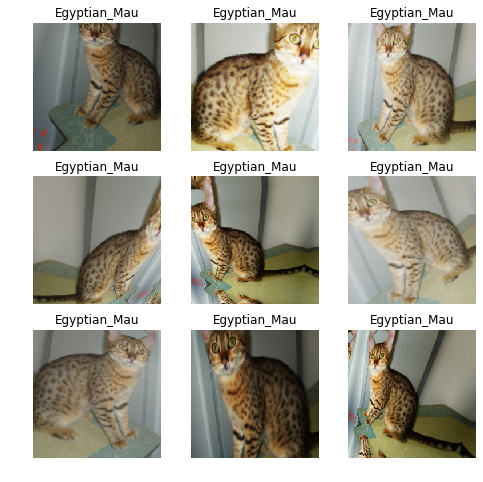

In [11]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [0]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)
# as usual: resnet34 on 224x224 images

In [18]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

In [19]:
# unfreeze and train some more
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

HERE THE IMPORTANT BIT, PROGRESSIVE RESIZING!

We upscale the images to 352x352 now and train some more!

https://miguel-data-sc.github.io/2017-11-23-second/

In [0]:
#upscale the data
data = get_data(352,bs)
# pass the newdata to the learner (the rest is handled by fastai)
learn.data = data

In [21]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

In [0]:
learn.save('352')

Let's learn now how a convolutional network works! to see what's going on!

## Convolution kernel

In [0]:
data = get_data(352,16)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

In [67]:
idx=1
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

Category British_Shorthair

In [0]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [69]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [70]:
k.shape

torch.Size([1, 3, 3, 3])

In [76]:
t = data.valid_ds[idx][0].data; t.shape

torch.Size([3, 352, 352])

In [77]:
t[None].shape # this is a minibatch of size one, expanding the original [3,352,352]
# t[None] creates a new unit axies as the first dimension

torch.Size([1, 3, 352, 352])

In [0]:
edge = F.conv2d(t[None], k)

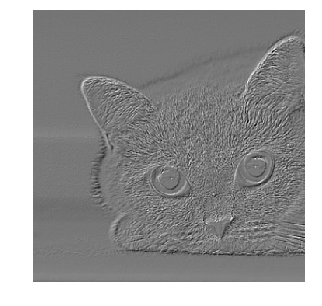

In [79]:
show_image(edge[0], figsize=(5,5));

In [80]:
data.c

37

In [81]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [82]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

## Heatmap

In [0]:
m = learn.model.eval();

In [0]:
xb,_ = data.one_item(x) # this creates a minibatch of one item
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
from fastai.callbacks.hooks import *

In [0]:
# model[0] in fastai will always be the frozen part in transfer learning, in the case of CNN is the actual convolutional part
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g: 
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
hook_a,hook_g = hooked_backward()

In [88]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [89]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

In [91]:
show_heatmap(avg_acts) # so cute!

Cuteness aside, we can see that the 11x11 averaged feature map looks like (expanded to 352 to match the img_size, remember convolutions essentially shrink the image, that's why we can simply expand it).

Recall that 'features' are expresse in the 512 channels in the [512,11,11] final convolution kernel and the 11x11 part maps essentially how 'featury' is the part of the image in the receptive field of that kernel.
Think of the first (of 512) features are 'furryness';  the top-left element of `acts[0]` (which is a 11x11 matrix) correspond essentially to how 'furry' is the top-left corner of the image (the exact amount of pixels will depend on the number and types of convolution used, see [receptive field](http://blog.christianperone.com/2017/11/the-effective-receptive-field-on-cnns/)).

When we then average across the 512 channels/features, we simply get how activated was on average that part of the image! 

Now take a step back and return to the 512x11x11 tensor. Think of applying MaxPooling2D after it, as it happens in the model. This means that if some feature had a match in SOME part of the image (which implies high activation in the 'pixel'/element), the corresponding element after MaxPooling will be high.

Since we know that for the model to (hopefully correctly) classify the image it simply takes a combination of the final 512-elements vector, looking at WHERE (in the 11x11 image, but also in their receptive fields) those last features had high activations will tell us essentially what part of the image made our model decide to classify it (the image) as it (the model) did.

BAM, this is the heatmap!

By the way, the fact that the model looks at a combination of the 512 features to decide how to classify the image is possibly the reason why hierarchical classification is not explored that much, as the model will LEARN SHARED FEATURES / REPRESENTATION for 'cattyness' and features for 'doggyness' (for all / irrespective of breeds!) and then learn how to combine those with more specific features to correctly guess the breed. All by itself (probably because it'll be easier and more robust when competing against the regularizations we're using).

To have a look at it we could store the 512 MaxPooled features (WHICH ARE ESSENTIALLY EMBEDDINGS FOR IMAGES! BAM!), do a dimensionality reduction of some sort and plot them to show how breeds of cats are close together but farther from dog breeds for examples, or cars...
With a sparse PCA we could even think of extracting what features represent cattyness etc ...

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [92]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [0]:
mult = (acts*grad_chan[...,None,None]).mean(0)

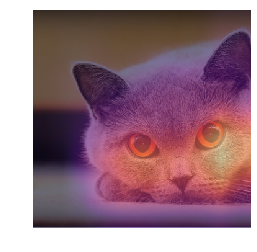

In [94]:
show_heatmap(mult)

In [145]:
!wget "https://drive.google.com/uc?export=download&id=1vWCfGX0eFbxF-xEYUGwQDTclBqQ4enr_" -O /content/cat_and_dog.jpg

fn = Path('/content/cat_and_dog.jpg') #Replace with your own image

--2019-10-15 11:24:17--  https://drive.google.com/uc?export=download&id=1vWCfGX0eFbxF-xEYUGwQDTclBqQ4enr_
Resolving drive.google.com (drive.google.com)... 74.125.133.113, 74.125.133.100, 74.125.133.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.133.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1di631vvetd0c4frutv4cqp709uvo8u1/1571133600000/00065539089677737849/*/1vWCfGX0eFbxF-xEYUGwQDTclBqQ4enr_?e=download [following]
--2019-10-15 11:24:17--  https://doc-0s-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1di631vvetd0c4frutv4cqp709uvo8u1/1571133600000/00065539089677737849/*/1vWCfGX0eFbxF-xEYUGwQDTclBqQ4enr_?e=download
Resolving doc-0s-70-docs.googleusercontent.com (doc-0s-70-docs.googleusercontent.com)... 74.125.133.132, 2a00:1450:400c:c07::84
Connecting to doc-0s-70-docs.googleusercontent.com (doc-0s

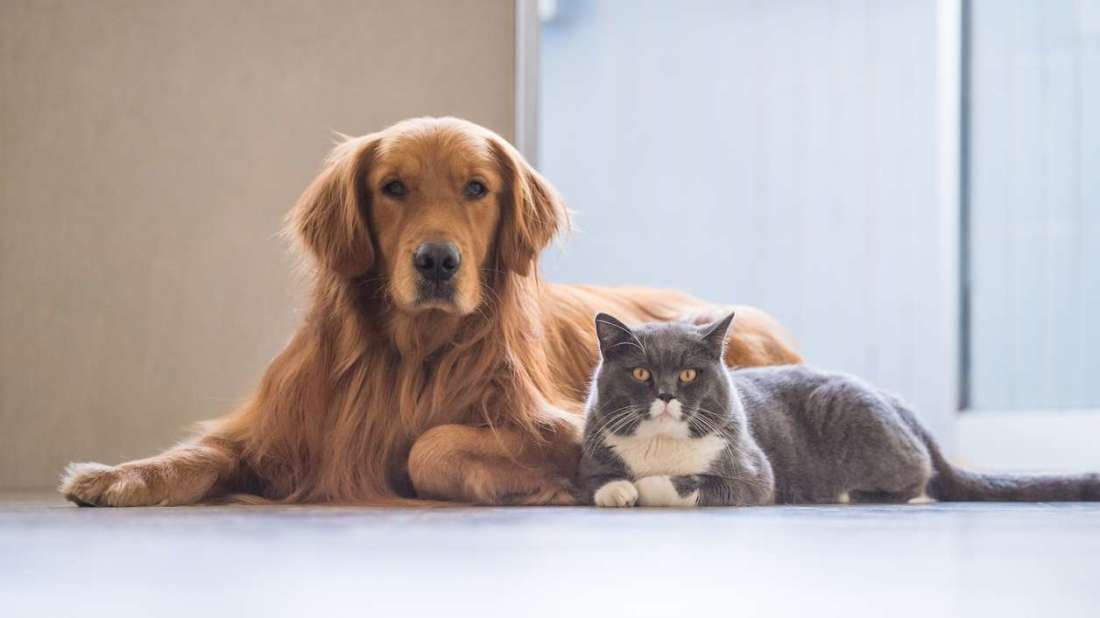

In [146]:
x = open_image(fn); x

In [152]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

y = m(xb).argmax()
yb = data.classes[y] ## so the model is predicting "British Shorthair"
print(yb)

British_Shorthair


In [0]:
hook_a,hook_g = hooked_backward(y)

Now we'll use `hook_g` as well,
you can see above that it is essentially the gradiend from the output to the last layer, *i.e.* providing informations as to which of the 512 (avg/max pooled) features produces higher degree of changes wrt to changed in the input(read as "is important") wrt to the final classification decision [for each class].

In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

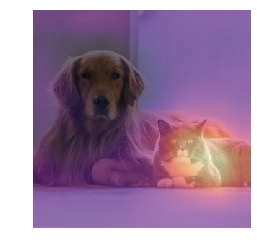

In [155]:
show_heatmap(mult)

And we can see that the model focused on the cat to predict british shorthair!
But what if we were instead interested in predictig the dog? Where would the model look here?

In [165]:
data.classes[18]
# note I don't think that's a cocker but it's probably the closest class...

'english_cocker_spaniel'

In [0]:
hook_a,hook_g = hooked_backward(18) # try 18 or 27

In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

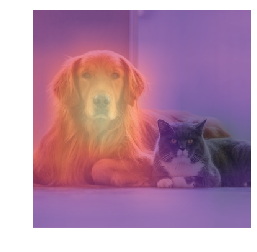

In [175]:
show_heatmap(mult)

It would look at the dog (and its ears!)

Ok so what happened here?

Citing the paper, as we said above as well (but written better :P)

`convolutional features naturallyretain spatial information which is lost in fully-connectedlayers,  so we can expect the last convolutional layers tohave the best compromise between high-level semantics anddetailed spatial information. The neurons in these layerslook for semantic class-specific information in the image.`.

Additionally though, their method (Grad-CAM)

`uses the gradient information flowing into the last convolutional layer of the CNN to understand the importance of each neuron for a decision of interest.`

note the **for a decision of interest**.

So we're essentially makeing use of the gradients and resulting preiction from the model (that was discarded before other than the final softmaxed and thresholded selected class) to identify important part of the image for each possible class!

`We perform a weighted combination of forward activation maps` where the weights are `partial linearization of the deep network downstream from A, and captures the importance of feature map k for a target class c.`

In common terms, as can be seen from the code above, the weights are the gradients flowing from the output of the net to this last activation of the conv layers (the 512x11x11 tensor in our case).

Further 

`We apply a ReLU to the linear combination of maps because we are only interested in the features that have a positive influence on the class of interest, i.e. pixelswhose intensity should be increasedin order to increase yc. Negative pixels are likely to belong to other categories inthe image.`

We don't use ReLU here, and thus in the first heatmap you can in fact see that the dog is shaded exaclty because those features are being de-weighted.

(I suggest reading the paper though as it is very clearly written! I particularly like that they're concerning themselves with how this viz help untrained human *trust* and *interpret* DL methods, which is highly important for ethics considerations)

## fin